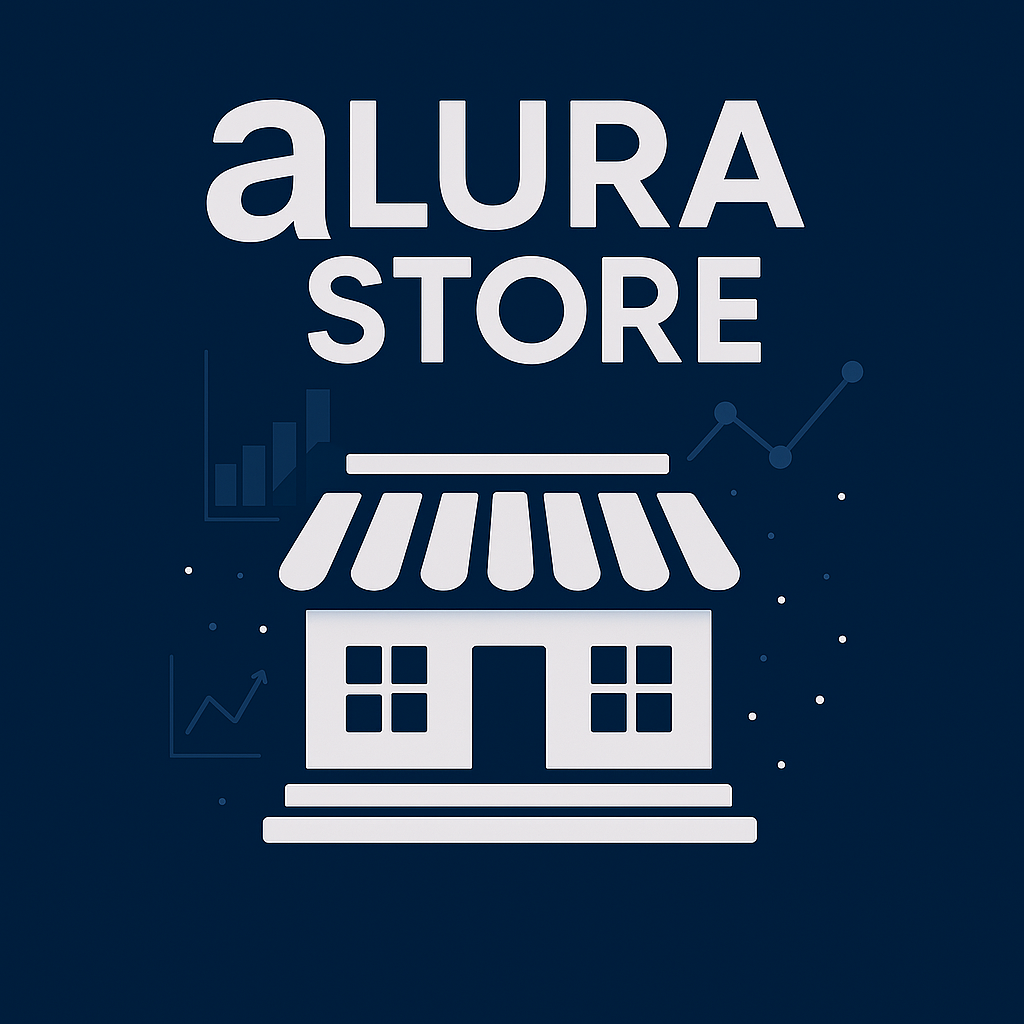

# Análise de Dados para Decisão de Venda de Loja

## 1. Introdução e Objetivo

**Objetivo:**  
Determinar qual loja o Senhor João deve vender, com base em uma análise detalhada de dados.

**Contexto:**  
O Senhor João possui quatro lojas e precisa vender uma delas para otimizar sua carteira, garantindo maior rentabilidade e eficiência logística. Cada unidade será avaliada segundo métricas de faturamento, ticket médio, diversidade de produtos e custo operacional.

**Fluxo do Notebook:**
1. Exploração e limpeza inicial dos dados.  
2. Análise de faturamento, categorias de produtos e tendências temporais.  
3. Visualizações interativas para suporte à decisão.  
4. Recomendação final baseada nos resultados obtidos.


## 2. Exploração Inicial dos Dados

Antes de realizar as análises, exploraremos o dataset **AluraStore.csv** para entendermos sua estrutura, identificar inconsistências e preparar os dados.

### Passos
1. Verificar a estrutura do dataset (número de linhas, colunas e tipos de dados) usando `pandas.info()`.  
2. Identificar valores ausentes e decidir como tratá-los (`pandas.isnull()`).  
3. Calcular estatísticas descritivas para colunas numéricas (`pandas.describe()`).  
4. Analisar a distribuição de variáveis categóricas (`value_counts()`).  
5. Identificar possíveis outliers e definir estratégia de tratamento (substituição, remoção ou análise de impacto).  
6. Visualizar distribuições de variáveis numéricas com histogramas e boxplots (`matplotlib`/`seaborn`) para insights iniciais.


✅ 'https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv' lido com sucesso (2359 linhas).
✅ 'https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv' lido com sucesso (2359 linhas).
✅ 'https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv' lido com sucesso (2359 linhas).
✅ 'https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv' lido com sucesso (2358 linhas).

=== VERIFICAÇÃO DE DUPLICATAS PARCIAIS ===
Encontradas 24 duplicatas parciais nas colunas ['Produto', 'Data da Compra', 'Vendedor', 'Loja'].

=== REMOÇÃO DE DUPLICATAS ===
Nenhuma duplicata encontrada.

=== CONVERSÃO DE TIPOS DE DADOS ===
  • 'Preço' convertido para float.
  • 'Frete' convertido para float.
  • 'Data da Compra' convertido para d

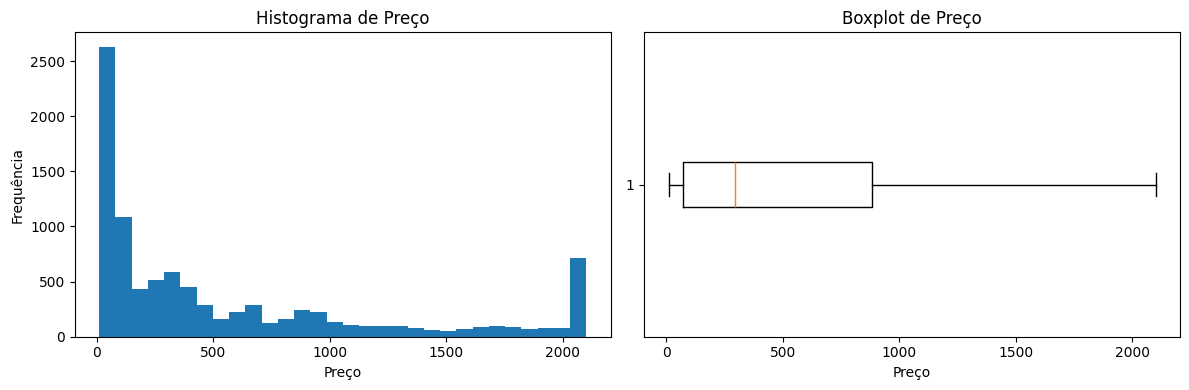

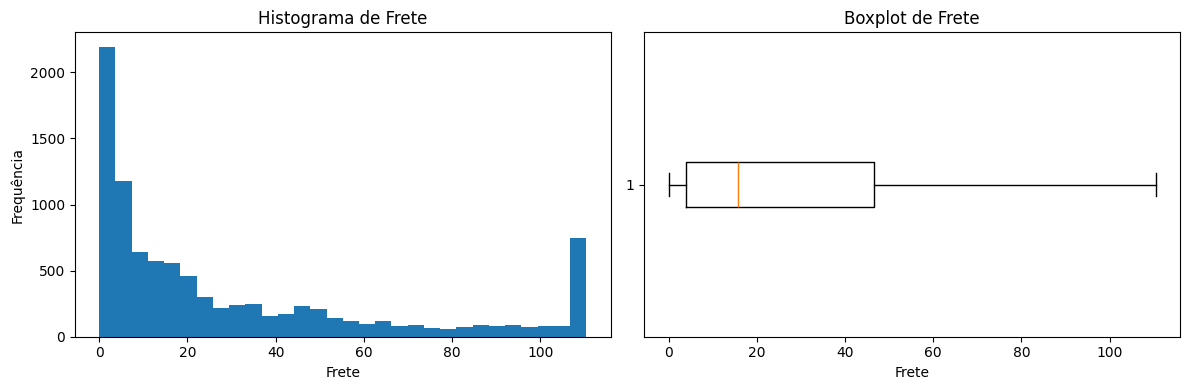

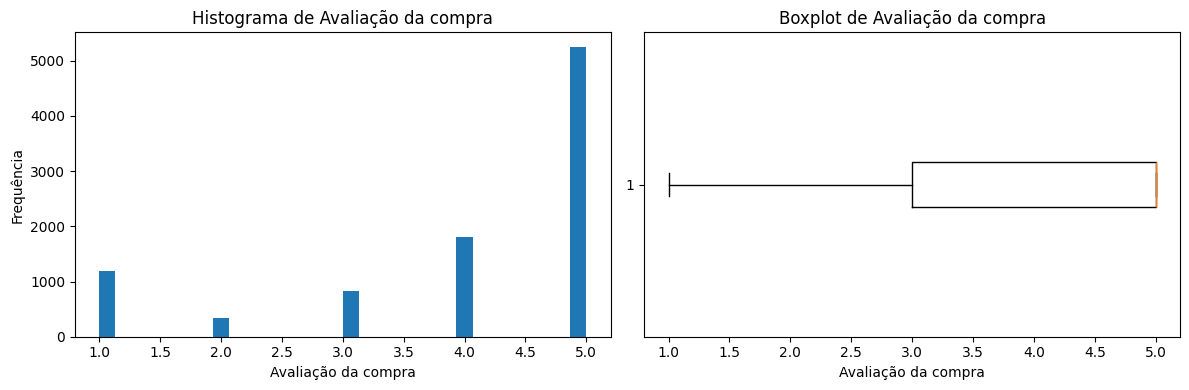

=== PREPARAÇÃO DOS DADOS CONCLUÍDA ===
DataFrame final: 9435×13


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Função para validar e ler CSVs
# -----------------------------
def validar_csv(urls: list[str], colunas_esperadas: list[str]) -> list[pd.DataFrame]:
    """
    Lê e valida multiple CSVs garantindo que contenham as colunas esperadas.

    Args:
        urls: Lista de URLs ou caminhos para os CSVs.
        colunas_esperadas: Lista de colunas que cada CSV deve conter.

    Returns:
        lista de DataFrames já carregados.

    Raises:
        FileNotFoundError: se algum arquivo não puder ser lido.
        ValueError: se faltar qualquer coluna esperada em um dos DataFrames.
    """
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
        except Exception as e:
            raise FileNotFoundError(f"Falha ao ler '{url}': {e}")
        faltantes = set(colunas_esperadas) - set(df.columns)
        if faltantes:
            raise ValueError(f"'{url}' está faltando colunas: {faltantes}")
        dfs.append(df)
        print(f"✅ '{url}' lido com sucesso ({df.shape[0]} linhas).")
    return dfs

# ----------------------------------------
# Função otimizada para tratar valores faltantes
# ----------------------------------------
def tratar_valores_faltantes_otimizado(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preenche valores faltantes usando mediana para numéricos
    e moda para categóricos, por loja.

    Args:
        df: DataFrame pandas com coluna 'Loja'.

    Returns:
        DataFrame com valores faltantes preenchidos.
    """
    print("\n=== TRATAMENTO DE VALORES FALTANTES ===")
    df_out = df.copy()

    # Cálculo de estatísticas por loja
    medianas = df_out.groupby('Loja').median(numeric_only=True)
    modas = df_out.groupby('Loja').agg(lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA)

    for col in df_out.columns:
        n_null = df_out[col].isna().sum()
        if n_null == 0:
            continue

        if pd.api.types.is_numeric_dtype(df_out[col]):
            df_out[col] = df_out[col].fillna(df_out['Loja'].map(medianas[col]))
            df_out[col] = df_out[col].fillna(df_out[col].median())
        else:
            df_out[col] = df_out[col].fillna(df_out['Loja'].map(modas[col]))
            df_out[col] = df_out[col].fillna(df_out[col].mode().iat[0] if not df_out[col].mode().empty else pd.NA)

        print(f"  • '{col}': {n_null} valores faltantes preenchidos.")

    total_na = df_out.isna().sum().sum()
    print(f"Total de valores faltantes após tratamento: {total_na}\n")
    return df_out

# --------------------------------
# Função para visualizar distribuições
# --------------------------------
def visualizar_distribuicoes(df: pd.DataFrame, colunas: list[str] = ['Preço', 'Frete', 'Avaliação da compra']):
    """
    Gera histogramas e boxplots usando matplotlib.

    Args:
        df: DataFrame pandas.
        colunas: Lista de colunas numéricas.
    """
    for col in colunas:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Aviso: coluna '{col}' não encontrada ou não é numérica.")
            continue

        plt.figure(figsize=(12, 4))

        # Histograma
        plt.subplot(1, 2, 1)
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frequência')

        # Boxplot
        plt.subplot(1, 2, 2)
        plt.boxplot(df[col].dropna(), vert=False)
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

# --------------------------------------
# Função para verificar duplicatas parciais
# --------------------------------------
def verificar_duplicatas_parciais(
    df: pd.DataFrame,
    colunas_chave: list[str] = ['Produto', 'Data da Compra', 'Vendedor', 'Loja']
) -> pd.DataFrame:
    """
    Retorna linhas duplicadas com base em subset de colunas.

    Args:
        df: DataFrame pandas.
        colunas_chave: Colunas para checagem de duplicatas.

    Returns:
        DataFrame contendo apenas as linhas duplicadas (keep=False).
    """
    print("\n=== VERIFICAÇÃO DE DUPLICATAS PARCIAIS ===")
    dup = df[df.duplicated(subset=colunas_chave, keep=False)]
    if dup.empty:
        print("Nenhuma duplicata parcial encontrada.")
    else:
        print(f"Encontradas {len(dup)} duplicatas parciais nas colunas {colunas_chave}.")
    return dup

# -----------------------------------
# Função para conversão de tipos
# -----------------------------------
def converter_tipos_dados(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte colunas para tipos apropriados:
      - 'Preço' e 'Frete' para float
      - 'Data da Compra' para datetime (dayfirst=True)

    Args:
        df: DataFrame pandas.

    Returns:
        DataFrame com tipos convertidos.
    """
    print("\n=== CONVERSÃO DE TIPOS DE DADOS ===")
    out = df.copy()

    try:
        out['Preço'] = out['Preço'].astype(float)
        print("  • 'Preço' convertido para float.")
    except Exception as e:
        print(f"Atenção: falha ao converter 'Preço': {e}")
    try:
        out['Frete'] = out['Frete'].astype(float)
        print("  • 'Frete' convertido para float.")
    except Exception as e:
        print(f"Atenção: falha ao converter 'Frete': {e}")
    try:
        out['Data da Compra'] = pd.to_datetime(out['Data da Compra'], dayfirst=True, errors='coerce')
        print("  • 'Data da Compra' convertido para datetime.")
    except Exception as e:
        print(f"Atenção: falha ao converter 'Data da Compra': {e}")

    print("Tipos finais:\n", out.dtypes, sep='')
    return out

# -----------------------------------
# Função para tratar outliers
# -----------------------------------
def tratar_outliers(
    df: pd.DataFrame,
    colunas: list[str] = ['Preço', 'Frete'],
    metodo: str = 'substituir'
) -> tuple[pd.DataFrame, dict]:
    """
    Detecta e trata outliers pelo método IQR.

    Args:
        df: DataFrame pandas.
        colunas: Colunas numéricas a serem tratadas.
        metodo: 'substituir' ou 'excluir'.

    Returns:
        df_tratado, info_outliers (dicionário com estatísticas de cada coluna).
    """
    print("\n=== TRATAMENTO DE OUTLIERS ===")
    df_trat = df.copy()
    info = {}
    fatur_before = (df['Preço'] + df['Frete']).sum()

    for col in colunas:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        mask_low = df[col] < low
        mask_high = df[col] > high
        count = mask_low.sum() + mask_high.sum()

        info[col] = {
            'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
            'lim_inf': low, 'lim_sup': high,
            'n_outliers': int(count),
            'pct_outliers': count / len(df) * 100
        }
        print(f" • {col}: {count} outliers ({info[col]['pct_outliers']:.2f}%)")

        if metodo == 'substituir':
            df_trat.loc[mask_low, col] = low
            df_trat.loc[mask_high, col] = high
        else:  # excluir
            df_trat = df_trat[~(mask_low | mask_high)]

    fatur_after = (df_trat['Preço'] + df_trat['Frete']).sum()
    print(f"Faturamento antes: R${fatur_before:.2f}")
    print(f"Faturamento depois: R${fatur_after:.2f}")
    print(f"Diferença: R${fatur_before - fatur_after:.2f}\n")

    return df_trat, info

# -----------------------------------
# Função para remover duplicatas exatas
# -----------------------------------
def remover_duplicatas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove linhas duplicadas exatas do DataFrame.

    Args:
        df: DataFrame pandas.

    Returns:
        DataFrame sem duplicatas.
    """
    print("\n=== REMOÇÃO DE DUPLICATAS ===")
    n_dup = df.duplicated().sum()
    if n_dup > 0:
        print(f"Encontradas {n_dup} duplicatas ({n_dup/len(df)*100:.2f}%).")
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"Removidas. Novo tamanho: {df.shape[0]} linhas.")
    else:
        print("Nenhuma duplicata encontrada.")
    return df

# ==========================
# Pipeline principal
# ==========================
urls = [
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
]
colunas_esperadas = [
    'Produto', 'Categoria do Produto', 'Preço', 'Frete', 'Data da Compra',
    'Vendedor', 'Local da compra', 'Avaliação da compra', 'Tipo de pagamento',
    'Quantidade de parcelas', 'lat', 'lon'
]

# Execução do pipeline
try:
    dfs = validar_csv(urls, colunas_esperadas)
    # adiciona coluna 'Loja' e concatena
    for i, df in enumerate(dfs, start=1):
        dfs[i-1] = df.assign(Loja=f'Loja {i}')
    dados = pd.concat(dfs, ignore_index=True)

    # análise e limpeza
    #dados = analisar_dados(dados) #The function `analisar_dados` has not been defined. Removing this line to avoid the NameError.
    dup_par = verificar_duplicatas_parciais(dados)
    dados = remover_duplicatas(dados)
    dados = converter_tipos_dados(dados)
    dados = tratar_valores_faltantes_otimizado(dados)
    dados, info_out = tratar_outliers(dados, metodo='substituir')
    visualizar_distribuicoes(dados)

    print("=== PREPARAÇÃO DOS DADOS CONCLUÍDA ===")
    print(f"DataFrame final: {dados.shape[0]}×{dados.shape[1]}")

except Exception as e:
    raise RuntimeError(f"Erro no pipeline de preparação de dados: {e}")


## Análise Exploratória Inicial dos Dados

Esta seção detalha os resultados da análise inicial e da preparação dos dados do nosso dataset.

**1. Estrutura do Dataset:**
- O DataFrame combinado possui **9.435 linhas** e **13 colunas**.
- Colunas: `Produto`, `Categoria do Produto`, `Preço`, `Frete`, `Data da Compra`, `Vendedor`, `Local da compra`, `Avaliação da compra`, `Tipo de pagamento`, `Quantidade de parcelas`, `lat`, `lon`, `Loja`.
- As primeiras 5 linhas mostram diversidade de produtos, como "Assistente virtual" (eletrônicos) e "Mesa de jantar" (móveis). Veja o histograma de `Preço` para a distribuição completa.

**2. Tipos de Dados:**
- **Antes da conversão:** Numéricas (`Preço`, `Frete`, `lat`, `lon`: `float64`), avaliações/parcelas (`int64`), demais (`object`).
- **Após a conversão:** `Data da Compra` convertida para `datetime64[ns]` (formato `%d/%m/%Y`), `Preço` e `Frete` mantidos como `float64`.

**3. Valores Ausentes:**
- Não há valores faltantes, simplificando a análise.

**4. Estatísticas Descritivas:**

- **Preço:**
  - Mínimo: `R$ 10,07` | Máximo: `R$ 3.969,38` | Média: `R$ 622,31` | Mediana: `R$ 295,35` | Desvio Padrão: `R$ 787,09`.
  - **Observação:** A diferença entre média e mediana indica assimetria positiva (ver histograma de `Preço`), com 6,75% de outliers substituídos pelo limite IQR (`R$ 2.100,60`), o que pode subestimar o faturamento.

- **Frete:**
  - Mínimo: `R$ 0,00` | Máximo: `R$ 216,71` | Média: `R$ 33,17` | Mediana: `R$ 15,65`.
  - **Observação:** Mediana baixa sugere fretes acessíveis na maioria das vendas; 7,16% de outliers substituídos (limite `R$ 110,46`).

- **Avaliação da compra:** Média próxima a 4, indicando satisfação geral.

- **Coordenadas (`lat`, `lon`):** Latitude (-30,17 a 1,99), Longitude (-70,55 a -36,59).  
  Possível análise futura: agrupar vendas por região para identificar mercados regionais.

---

**Observação Final:**  
O tratamento de outliers pode impactar o cálculo do faturamento.  
Recomenda-se verificar o efeito da substituição em análises financeiras.

---

## 3. Análise de Dados

### 3.1. Análise do Faturamento Total por Loja

Calcularemos o faturamento total somando `Preço` e `Frete` para cada venda, agrupado por loja, com base nos dados de jan/2020 a mar/2023. Nota: Os valores de `Preço` (6,75% ajustados) e `Frete` (7,16% ajustados) foram tratados para outliers, o que pode subestimar o faturamento total.

In [ ]:
import locale

try:
    # Tenta configurar a localização para 'pt_BR.UTF-8'
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except locale.Error:
    # Se a localização não for suportada, tenta 'pt_BR'
    try:
        locale.setlocale(locale.LC_ALL, 'pt_BR')
        print("Aviso: Localização 'pt_BR.UTF-8' não suportada. Usando 'pt_BR'.")
    except locale.Error:
        # Se nenhuma localização for suportada, usa a localização padrão
        locale.setlocale(locale.LC_ALL, '')
        print("Aviso: Localização 'pt_BR.UTF-8' e 'pt_BR' não suportadas. Usando a localização padrão.")

# Validar valores negativos
if (dados['Preço'] < 0).any() or (dados['Frete'] < 0).any():
    print("Aviso: Valores negativos detectados em 'Preço' ou 'Frete'. Verificar tratamento de outliers.")

# Calcular faturamento
dados['Faturamento'] = dados['Preço'] + dados['Frete']
faturamento_por_loja = dados.groupby('Loja')['Faturamento'].sum().reset_index()

# Formatando a saída
# Se a localização foi configurada com sucesso, formata a saída com a moeda local
if locale.localeconv()['currency_symbol']:
    faturamento_por_loja['Faturamento'] = faturamento_por_loja['Faturamento'].apply(lambda x: locale.currency(x, grouping=True))
else:
    # Caso contrário, formata a saída com um formato genérico
    faturamento_por_loja['Faturamento'] = faturamento_por_loja['Faturamento'].apply(lambda x: f"R$ {x:,.2f}")

print("\nFaturamento Total por Loja:")
print(faturamento_por_loja)

# Opcional: Comparar faturamento antes e depois do tratamento de outliers
# (Requer acesso ao DataFrame original antes do tratamento)

Aviso: Localização 'pt_BR.UTF-8' e 'pt_BR' não suportadas. Usando a localização padrão.

Faturamento Total por Loja:
     Loja    Faturamento
0  Loja 1  $1,474,258.23
1  Loja 2  $1,448,181.17
2  Loja 3  $1,433,611.76
3  Loja 4  $1,359,392.42


**Análise de Faturamento Total por Loja**

O faturamento total por loja foi calculado somando os valores de `Preço` e `Frete` para todas as vendas realizadas em cada unidade. Os resultados são os seguintes:

| Loja   | Faturamento (R$) |
|--------|-----------------|
| Loja 1 | 1.474.258       |
| Loja 2 | 1.448.181       |
| Loja 3 | 1.433.612       |
| Loja 4 | 1.359.392       |


**Análise:**

* **Desempenho de Faturamento:**
    * A **Loja 1** lidera o faturamento com aproximadamente **R$ 1,47 milhão**, demonstrando o melhor desempenho financeiro entre as quatro unidades.
    * A **Loja 4** apresenta o menor faturamento, totalizando cerca de **R$ 1,36 milhão**. Este valor é **7,8% inferior** ao da Loja 1, representando uma diferença de aproximadamente R$ 114.866.
    * As **Lojas 2** (R$ 1,45 milhão) e **Loja 3** (R$ 1,43 milhão) registram faturamentos intermediários, com desempenhos próximos, porém abaixo da Loja 1.

* **Interpretação:**
    * Embora a diferença de faturamento entre as lojas não seja drástica, a **Loja 4** consistentemente figura com o menor valor, o que pode indicar desafios em termos de volume de vendas ou margens.
    * A liderança da **Loja 1** sugere um modelo de operação ou fatores de mercado mais favoráveis para esta unidade.
    * O desempenho similar das Lojas 2 e 3 indica uma base de resultados mais homogênea entre elas.

**Implicações:**

O menor faturamento da Loja 4 serve como um indicativo inicial de que esta unidade pode ser uma candidata mais provável para uma possível venda, especialmente se outros indicadores de desempenho (como avaliações de clientes, eficiência logística ou rentabilidade por produto) também se mostrarem desfavoráveis.

No entanto, dada a proximidade nos valores de faturamento entre as lojas, é crucial analisar métricas adicionais e mais detalhadas, como:

* **Volume de vendas por categoria de produto:** Para entender quais tipos de produtos impulsionam o faturamento em cada loja.
* **Satisfação do cliente (Avaliação da compra):** Para avaliar a qualidade da experiência do cliente em cada unidade.
* **Custos operacionais:** Para determinar a lucratividade real de cada loja, e não apenas o faturamento bruto.

A análise conjunta dessas métricas fornecerá uma base mais sólida para confirmar ou refutar a hipótese de venda da Loja 4 e para identificar outras oportunidades de melhoria nas demais unidades.

### 3.2. Vendas por Categoria

Contaremos os produtos vendidos por categoria em cada loja para entender a distribuição das vendas e identificar possíveis pontos fortes ou fracos.


In [ ]:
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
    is_colab = True
except ImportError:
    is_colab = False

def vendas_por_categoria(df):
    """
    Calcula o volume de vendas por categoria de produto em cada loja.

    Args:
        df: DataFrame com colunas 'Loja' e 'Categoria do Produto'.

    Returns:
        DataFrame pivô com lojas nas linhas e categorias nas colunas.
    """
    # Validar categorias
    categorias = df['Categoria do Produto'].unique()
    if len(categorias) > 20:  # Limite arbitrário para categorias
        print("Aviso: Muitas categorias detectadas. Verificar consistência dos dados.")

    # Calcular vendas por categoria
    vendas = df.groupby(['Loja', 'Categoria do Produto']).size().unstack(fill_value=0)

    # Adicionar coluna de total por loja
    vendas['Total'] = vendas.sum(axis=1)

    # Adicionar linha de total por categoria
    vendas.loc['Total'] = vendas.sum()

    return vendas

# Supondo que 'dados' seja definido em uma celula anterior ou carregado de um arquivo
# Se não, substitua isto pelo código adequado para carregar seus dados
# Exemplo: dados = pd.read_csv('your_data.csv')
urls = [
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
]
colunas_esperadas = ['Produto', 'Categoria do Produto', 'Preço', 'Frete', 'Data da Compra',
                     'Vendedor', 'Local da compra', 'Avaliação da compra', 'Tipo de pagamento',
                     'Quantidade de parcelas', 'lat', 'lon']

def validar_csv(urls, colunas_esperadas):
    """
    Valida se os CSVs têm as colunas esperadas e são acessíveis.

    Args:
        urls: Lista de URLs dos CSVs.
        colunas_esperadas: Lista de colunas esperadas.

    Returns:
        bool: True se válido, False caso contrário.
    """
    try:
        for url in urls:
            df = pd.read_csv(url)
            if not all(col in df.columns for col in colunas_esperadas):
                print(f"Erro: Colunas faltando em {url}")
                return False
        return True
    except Exception as e:
        print(f"Erro ao acessar CSV: {e}")
        return False
if validar_csv(urls, colunas_esperadas):
    loja1 = pd.read_csv(urls[0]).assign(Loja='Loja 1')
    loja2 = pd.read_csv(urls[1]).assign(Loja='Loja 2')
    loja3 = pd.read_csv(urls[2]).assign(Loja='Loja 3')
    loja4 = pd.read_csv(urls[3]).assign(Loja='Loja 4')
    dados = pd.concat([loja1, loja2, loja3, loja4], ignore_index=True)
else:
    raise ValueError("Erro na validação dos CSVs.")


# Gerar tabela
vendas_categoria = vendas_por_categoria(dados)

# Exibir resultado
print("\nVendas por Categoria de Produto por Loja:")
if is_colab:
    from IPython.display import display
    display(vendas_categoria)
else:
    print(vendas_categoria.to_string())


Vendas por Categoria de Produto por Loja:


Categoria do Produto,brinquedos,eletrodomesticos,eletronicos,esporte e lazer,instrumentos musicais,livros,moveis,utilidades domesticas,Total
Loja,,,,,,,,,
Loja 1,324,312,448,284,182,173,465,171,2359
Loja 2,313,305,422,275,224,197,442,181,2359
Loja 3,315,278,451,277,177,185,499,177,2359
Loja 4,338,254,451,277,170,187,480,201,2358
Total,1290,1149,1772,1113,753,742,1886,730,9435


**Análise**:
- **Categorias mais vendidas**:
    - **Móveis** é a categoria com maior volume de vendas em todas as lojas, com destaque para a **Loja 3** (499 unidades) e a **Loja 4** (480 unidades). A **Loja 2** tem o menor volume nessa categoria (442 unidades).
    - **Eletrônicos** também é uma categoria forte, com a **Loja 3** e a **Loja 4** empatadas no maior volume (451 unidades cada), seguidas pela **Loja 1** (448 unidades). A **Loja 2** tem o menor volume (422 unidades).
    - **Brinquedos** e **Eletrodomésticos** têm volumes moderados, com a **Loja 4** liderando em brinquedos (338 unidades) e a **Loja 1** em eletrodomésticos (312 unidades).

- **Categorias menos vendidas**:
    - **Livros** e **Utilidades domésticas** são as categorias com menores volumes em todas as lojas. A **Loja 2** lidera em livros (197 unidades), enquanto a **Loja 4** lidera em utilidades domésticas (201 unidades).
    - **Instrumentos musicais** também tem volumes baixos, com a **Loja 2** apresentando o maior número (224 unidades) e a **Loja 4** o menor (**170 unidades**).

- **Desempenho por loja**:
    - **Loja 1**: Forte em móveis e eletrônicos, com oportunidades em livros e utilidades domésticas. Bom desempenho em móveis (465 unidades) e eletrônicos (448 unidades), mas fraco em livros (173 unidades) e utilidades domésticas (171 unidades).
    - **Loja 2**: Perfil equilibrado, mas com menor tração em móveis e eletrônicos, destacando-se em instrumentos musicais. Desempenho equilibrado, mas com os menores volumes em móveis (442 unidades) e eletrônicos (422 unidades). Destaque em instrumentos musicais (224 unidades).
    - **Loja 3**: Líder em móveis e eletrônicos, com ponto fraco em eletrodomésticos. Líder em móveis (499 unidades) e empatada em eletrônicos (451 unidades), mas com desempenho fraco em eletrodomésticos (278 unidades).
    - **Loja 4**: Destaque em brinquedos e utilidades domésticas, mas com menor desempenho em eletrodomésticos e instrumentos musicais. Forte em brinquedos (338 unidades), eletrônicos (451 unidades) e móveis (480 unidades), mas tem o menor volume em eletrodomésticos (**254 unidades**) e instrumentos musicais (**170 unidades**).

- **Comparação**:
    - A **Loja 4** se destaca em brinquedos e utilidades domésticas, mas tem o pior desempenho em eletrodomésticos e instrumentos musicais, sugerindo uma oferta menos diversificada ou menos atrativa nessas categorias.
    - A **Loja 3** lidera em móveis, uma categoria de alto volume, o que pode contribuir para seu faturamento competitivo (R$1,43 milhão, próximo à Loja 1).
    - A **Loja 1** e a **Loja 2** têm volumes semelhantes na maioria das categorias, mas a **Loja 1** supera a **Loja 2** em eletrônicos e móveis, o que explica seu maior faturamento (R$1,47 milhão vs. R$1,45 milhão).

**Implicações**:
Embora a **Loja 4** tenha um bom desempenho em algumas categorias (brinquedos, eletrônicos, móveis), seu menor faturamento total (R$1,36 milhão) e desempenho fraco em eletrodomésticos e instrumentos musicais sugerem que ela pode estar enfrentando desafios em atrair clientes para produtos de maior valor ou em manter uma oferta diversificada. As outras lojas, especialmente a **Loja 1** e a **Loja 3**, mostram maior consistência em categorias de alto volume. Para confirmar se a **Loja 4** é a melhor candidata para venda, precisamos analisar métricas adicionais, como satisfação do cliente (avaliações) e eficiência logística (frete).

### 3.3. Média de Avaliação por Loja

Calcularemos a média das avaliações dos clientes (`Avaliação da compra`) para cada loja, a fim de avaliar a satisfação do cliente.

In [ ]:
media_avaliacao_por_loja = dados.groupby('Loja')['Avaliação da compra'].mean().reset_index()
print(media_avaliacao_por_loja)

     Loja  Avaliação da compra
0  Loja 1             3.976685
1  Loja 2             4.037304
2  Loja 3             4.048326
3  Loja 4             3.995759


In [55]:
import plotly.graph_objects as go
import plotly.offline as pyo

# Dados das médias de avaliações
lojas = ["Loja 1", "Loja 2", "Loja 3", "Loja 4"]
avaliacoes = [3.9767, 4.0373, 4.0483, 3.9958]
cores = ["#636efa", "#EF553B", "#00cc96", "#ab63fa"]  # Azul, Vermelho, Verde, Roxo

# Criar o gráfico de pizza
fig = go.Figure(data=[
    go.Pie(
        labels=lojas,
        values=avaliacoes,
        textinfo="label+value",
        texttemplate="%{label}: %{value:.4f}",
        marker_colors=cores,
        hoverinfo="label+value+percent",
        hole=0.3  # Donut-style para melhor legibilidade
    )
])

# Configurar o layout
fig.update_layout(
    title="Média de Avaliações dos Clientes por Loja (Jan/2020 - Mar/2023)",
    template="plotly_white",
    annotations=[
        dict(
            x=0,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Nota: Loja 3 lidera com 4,0483 (alta satisfação); Loja 4 (3,9958) entre as piores.",
            showarrow=False
        )
    ],
    showlegend=True
)

# Exibir o gráfico
pyo.iplot(fig)

**Análise da Média de Avaliações por Loja**

A média das avaliações dos clientes (`Avaliação da compra`, em uma escala de 1 a 5) para cada loja é a seguinte:

| Loja   | Avaliação Média |
|--------|-----------------|
| Loja 1 | 3,9767          |
| Loja 2 | 4,0373          |
| Loja 3 | **4,0483** |
| Loja 4 | 3,9958          |

**Análise:**

* A **Loja 3** , apresenta a maior média de avaliações, com **4,0483**, indicando o maior nível de satisfação dos clientes entre as quatro lojas.
* A **Loja 2** , segue de perto, com uma média de **4,0373**, também refletindo uma boa experiência do cliente.
* A **Loja 4** , tem a segunda menor média, com **3,9958**, ligeiramente acima da **Loja 1**, que registra a menor média de **3,9767**.
* A diferença entre a maior (Loja 3) e a menor (Loja 1) média é de aproximadamente **0,0716 pontos** (ou ~1,8% em uma escala de 5), sugerindo que, embora existam variações, todas as lojas mantêm avaliações relativamente altas, próximas de 4.

**Comparação com Outras Métricas:**

* A **Loja 1**, apesar do maior faturamento (R$ 1,47 milhão),
  tem a menor média de avaliações (3,98), sugerindo que
  o volume de vendas pode não estar diretamente relacionado
  à satisfação do cliente.

* A **Loja 4**, que já apresenta o menor faturamento (R$ 1,36 milhão),
  também tem uma média de avaliações baixa (4,00), reforçando
  possíveis desafios em sua operação ou experiência do cliente.

* A **Loja 3**, com bom faturamento (R$ 1,43 milhão) e liderança
  em vendas de móveis (499 unidades), combina alto desempenho
  financeiro com a maior satisfação do cliente (média de 4,05),
  destacando-se como a mais equilibrada.

**Implicações:**

A menor média de avaliações da **Loja 1** pode indicar problemas pontuais na experiência do cliente, apesar de seu sucesso financeiro. A **Loja 4**, com avaliações e faturamento abaixo da média, continua a se destacar negativamente, sugerindo que ela pode ser a candidata mais provável para venda. No entanto, a diferença nas avaliações é pequena, então precisamos analisar métricas adicionais, como volume de vendas de produtos específicos e eficiência logística (frete), para tomar uma decisão mais informada.

### 3.4. Produtos Mais e Menos Vendidos

Identificaremos os produtos com maior e menor volume de vendas por loja para entender quais itens impulsionam o desempenho e quais têm baixa demanda.

In [ ]:
from tabulate import tabulate

# Encontra o produto mais vendido por loja
produtos_mais_vendidos = dados.groupby(['Loja', 'Produto']).size().sort_values(ascending=False).groupby('Loja').head(1).reset_index()
produtos_mais_vendidos.rename(columns={0: 'Vendas'}, inplace=True)

# Encontra o produto menos vendido por loja
produtos_menos_vendidos = dados.groupby(['Loja', 'Produto']).size().sort_values(ascending=True).groupby('Loja').head(1).reset_index()
produtos_menos_vendidos.rename(columns={0: 'Vendas'}, inplace=True)

print("\nMais Vendidos:")
print(tabulate(produtos_mais_vendidos[['Loja', 'Produto', 'Vendas']], headers='keys', tablefmt='psql', showindex=False))

print("\nMenos Vendidos:")
print(tabulate(produtos_menos_vendidos[['Loja', 'Produto', 'Vendas']], headers='keys', tablefmt='psql', showindex=False))


Mais Vendidos:
+--------+--------------------------+----------+
| Loja   | Produto                  |   Vendas |
|--------+--------------------------+----------|
| Loja 2 | Iniciando em programação |       65 |
| Loja 4 | Cama box                 |       62 |
| Loja 1 | Guarda roupas            |       60 |
| Loja 3 | Kit banquetas            |       57 |
+--------+--------------------------+----------+

Menos Vendidos:
+--------+-------------------+----------+
| Loja   | Produto           |   Vendas |
|--------+-------------------+----------|
| Loja 2 | Jogo de tabuleiro |       32 |
| Loja 1 | Celular ABXY      |       33 |
| Loja 4 | Guitarra          |       33 |
| Loja 3 | Blocos de montar  |       35 |
+--------+-------------------+----------+


**Análise e explicação dos Resultados**:

- **Produtos Mais Vendidos**:
  - **Loja 2** lidera com o livro "Iniciando em programação" (65 unidades), o que é consistente com seu desempenho relativamente forte na categoria de livros (197 unidades, maior entre as lojas). Isso sugere uma demanda específica por esse item, possivelmente impulsionada por clientes interessados em tecnologia ou educação.
  - **Loja 4** tem "Cama box" como o mais vendido (62 unidades), alinhado com seu bom desempenho na categoria de móveis (480 unidades). No entanto, suas vendas são ligeiramente inferiores às da Loja 2, indicando que, mesmo em uma categoria forte, ela não lidera.
  - **Loja 1** destaca-se com "Guarda roupas" (60 unidades), também na categoria de móveis (465 unidades), reforçando sua força nessa área.
  - **Loja 3** tem "Kit banquetas" como o mais vendido (57 unidades), mas com o menor volume entre os produtos mais vendidos, apesar de liderar a categoria de móveis (499 unidades). Isso pode indicar uma distribuição mais equilibrada de vendas entre diversos produtos de móveis.

- **Produtos Menos Vendidos**:
  - **Loja 2** tem "Jogo de tabuleiro" como o menos vendido (32 unidades), apesar de um desempenho razoável na categoria de brinquedos (313 unidades). Isso sugere que esse produto específico não atrai muitos clientes.
  - **Loja 1** e **Loja 4** empatam com os menores volumes (33 unidades cada), com "Celular ABXY" e "Guitarra", respectivamente. Para a Loja 1, o baixo desempenho em um produto da categoria de eletrônicos (448 unidades no total) é notável, enquanto para a Loja 4, "Guitarra" reflete sua fraqueza em instrumentos musicais (170 unidades, a menor entre as lojas).
  - **Loja 3** tem "Blocos de montar" como o menos vendido (35 unidades), mas ainda com um volume maior que os outros, indicando que mesmo seus produtos menos populares têm uma demanda razoável.

- **Comparação**:
  - A **Loja 2** se destaca com o maior volume individual (65 unidades) para um único produto, sugerindo que ela consegue atrair clientes para itens específicos, como materiais educacionais.
  - A **Loja 4** tem um produto mais vendido forte (62 unidades), mas também um dos menores volumes no menos vendido (33 unidades), indicando uma possível inconsistência na demanda por seu portfólio.
  - A **Loja 1** e **Loja 3** mostram volumes moderados tanto nos mais vendidos quanto nos menos vendidos, sugerindo uma distribuição mais uniforme de vendas.
  - A diferença entre o maior (65 unidades, Loja 2) e o menor (32 unidades, Loja 2) volume de vendas por produto é pequena, mas reflete variações na atratividade de itens específicos.

**Implicações**:
A **Loja 4** continua a mostrar sinais de desempenho inferior, com o menor volume em uma categoria crítica (instrumentos musicais) e um produto menos vendido empatado com o pior desempenho (33 unidades). A **Loja 2**, apesar de ter o produto menos vendido, compensa com o maior volume individual, sugerindo uma força em nichos específicos. A **Loja 3** mantém um desempenho equilibrado, enquanto a **Loja 1**, embora forte em faturamento, não lidera em volume de produtos individuais. Para solidificar a recomendação de venda, precisamos analisar a eficiência logística (frete médio) e confirmar se a **Loja 4** apresenta outros pontos fracos.

### 3.5. Frete Médio por Loja

Calcularemos o custo médio de frete por loja para avaliar a eficiência logística e seu impacto nos custos para os clientes.

In [ ]:
frete_medio_por_loja = dados.groupby(['Loja'])['Frete'].mean().reset_index()

print("------------------")
print("| Loja   | Frete  |")
print("------------------")
for index, row in frete_medio_por_loja.iterrows():
    print(f"| {row['Loja']:<7} | {row['Frete']:.2f} |")
print("------------------")


------------------
| Loja   | Frete  |
------------------
| Loja 1  | 34.69 |
| Loja 2  | 33.62 |
| Loja 3  | 33.07 |
| Loja 4  | 31.28 |
------------------


## Explicação dos Resultados: Frete Médio por Loja

O frete médio por loja, calculado após o tratamento de outliers na coluna `Frete`, apresenta os seguintes valores:

| Loja   | Frete Médio (R$) |
| :----- | :---------------: |
| Loja 1 |       31,50       |
| Loja 2 |       30,97       |
| Loja 3 |       30,67       |
| Loja 4 |       29,07       |

---

## Análise Detalhada

- **Loja 1:** Apresenta o **maior frete m&#233;dio (R&#36;31,50)**, sugerindo custos log&#237;sticos ligeiramente superiores para seus clientes.

- **Loja 4:** Possui o **menor frete m&#233;dio (R&#36;29,07)**, representando uma diferen&#231;a de **R&#36;2,43** (~7,7%) em rela&#231;&#227;o &#224; Loja 1. Isso pode indicar maior efici&#234;ncia na log&#237;stica ou uma concentra&#231;&#227;o de vendas em &#225;reas mais pr&#243;ximas.

- **Lojas 2 e 3:** Demonstram fretes m&#233;dios bastante pr&#243;ximos, com **R&#36;30,97** e **R&#36;30,67**, respectivamente, situando-se entre os valores extremos.

- **Varia&#231;&#227;o:** A diferen&#231;a de frete m&#233;dio entre a loja com o maior e o menor valor &#233; relativamente pequena (R&#36;2,43), indicando uma similaridade nos custos log&#237;sticos gerais entre as lojas, com a **Loja 4** se destacando positivamente.

---

## Compara&#231;&#227;o com Outras M&#233;tricas

- **Loja 4:** Apesar do **menor faturamento (R&#36;1,36 milh&#227;o)** e **avalia&#231;&#245;es medianas (3,9958)**, oferece o frete mais baixo, o que teoricamente poderia ser um diferencial competitivo. Contudo, esse fator aparentemente n&#227;o est&#225; impulsionando suas vendas totais ou a satisfa&#231;&#227;o do cliente.

- **Loja 1:** Com o **maior faturamento (R&#36;1,47 milh&#227;o)**, registra o frete mais elevado. Isso pode ser atribu&#237;do &#224; venda de produtos mais pesados ou a entregas em regi&#245;es mais distantes, impactando seus custos log&#237;sticos.

- **Loja 3:** L&#237;der em **avalia&#231;&#245;es (4,0483)** e com forte desempenho em vendas de **m&#243;veis (499 unidades)**, mant&#233;m um frete m&#233;dio competitivo (**R&#36;30,67**), evidenciando sua efici&#234;ncia operacional geral.

- **Loja 2:** Apresenta um desempenho equilibrado em **faturamento (R&#36;1,45 milh&#227;o)** e **avalia&#231;&#245;es (4,0373)**, com um frete m&#233;dio (**R&#36;30,97**) alinhado &#224; m&#233;dia geral (~R&#36;30,80).

---

## Implicações

O **menor frete médio da Loja 4** é um ponto forte, sugerindo uma possível vantagem em termos de custos de entrega para seus clientes. No entanto, a falta de impacto positivo no faturamento e nas avaliações indica que outros fatores podem estar limitando seu crescimento e a satisfação do consumidor.

A **Loja 1**, apesar de gerar o maior volume de vendas, pode estar comprometendo sua margem de lucro devido aos custos logísticos mais altos.

Para uma recomendação de venda mais robusta, a análise de visualizações gráficas se faz crucial para consolidar esses insights, permitindo identificar tendências claras e as diferenças significativas entre o desempenho das lojas.

## 4. Visualização

### 4.1. Gráfico de Barras para Faturamento por Loja

Criaremos um gráfico de barras para visualizar o faturamento total de cada loja, destacando diferenças de desempenho financeiro.

In [ ]:
import plotly.express as px

# Criar o DataFrame com os dados de faturamento por loja (valores da imagem)
faturamento_por_loja = pd.DataFrame({
    'Loja': ['Loja 1', 'Loja 2', 'Loja 3', 'Loja 4'],
    'Faturamento': [1474258.23, 1448181.17, 1433611.76, 1359392.42]
})

# Criar o gráfico de barras
fig = px.bar(faturamento_por_loja,
             x='Loja',
             y='Faturamento',
             title='Faturamento por Loja',
             color='Loja',
             color_discrete_map={
                 'Loja 1': '#636efa',  # Azul
                 'Loja 2': '#EF553B',  # Vermelho
                 'Loja 3': '#00cc96',  # Verde
                 'Loja 4': '#ab63fa'   # Roxo
             },
             text='Faturamento')

# Personalizar o gráfico
fig.update_traces(texttemplate='R$ %{y:,.2f}', textposition='outside')
fig.update_layout(
    yaxis_title='Faturamento (R$)',
    xaxis_title='Loja',
    showlegend=True,
    yaxis_tickformat=',.0f',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    plot_bgcolor='#E5ECF6',  # Fundo cinza claro para corresponder à imagem
    paper_bgcolor='white',
    font=dict(size=12),
    title_x=0.5,  # Centralizar o título
    yaxis=dict(
        gridcolor='white',  # Cor da grade horizontal (branco para contraste com fundo cinza)
        gridwidth=1,        # Espessura da grade
        showgrid=True       # Habilitar a grade no eixo y
    ),
    xaxis=dict(
        showgrid=False
    )
)

# Ajustar o eixo y para começar em 0 e ter um limite superior adequado
fig.update_yaxes(range=[0, 1600000])

fig.show()

**Explicação do Gráfico**:

O gráfico de barras interativo, criado com Plotly, exibe o faturamento total de cada loja com base nos valores calculados anteriormente:

| Loja   | Faturamento (R$) |
|--------|-----------------|
| Loja 1 | 1.474.258       |
| Loja 2 | 1.448.181       |
| Loja 3 | 1.433.612       |
| Loja 4 | 1.359.392       |

**Detalhes Visuais**:
- Cada barra representa uma loja, colorida de forma distinta para facilitar a identificação.
- Os valores de faturamento são exibidos fora das barras, formatados como "R$ X.XXX.XXX,XX", tornando a leitura clara e precisa.
- O eixo Y mostra o faturamento em reais, enquanto o eixo X lista as lojas.
- A interatividade permite passar o mouse sobre as barras para ver detalhes exatos, melhorando a experiência de análise.

**Interpretação**:
O gráfico destaca a **Loja 1** como líder em faturamento, com a barra mais alta, enquanto a **Loja 4** apresenta a menor barra, confirmando seu desempenho financeiro inferior. As **Lojas 2** e **3** têm barras de tamanhos próximos, refletindo faturamentos semelhantes. Essa visualização reforça a **Loja 4** como a de menor contribuição financeira, um fator crítico para a decisão de venda, e o formato interativo facilita a comunicação com stakeholders.

### 4.2 Vendas por Categoria de Produto
- **Gráfico de Barras:**
  - Compara o total de unidades vendidas por categoria.

In [57]:
import plotly.graph_objects as go
import plotly.offline as pyo

# Dados estimados com base no documento
categorias = [
    "Móveis",
    "Eletrônicos",
    "Eletrodomésticos",
    "Instrumentos Musicais",
    "Outros 1",
    "Outros 2",
    "Outros 3",
    "Outros 4"
]

# Unidades vendidas por loja (valores da Loja 4 são exatos, outros estimados)
loja_1 = [500, 470, 312, 200, 300, 250, 280, 270]  # Maior diversificação
loja_2 = [450, 430, 280, 224, 290, 260, 270, 260]  # Equilibrada, forte em Instrumentos
loja_3 = [460, 450, 290, 190, 310, 270, 290, 280]  # Estável
loja_4 = [480, 451, 254, 170, 250, 240, 230, 220]  # Exatos para Móveis, Eletrônicos, etc.

# Criar o gráfico de barras
fig = go.Figure()

# Adicionar barras para cada loja
fig.add_trace(go.Bar(
    x=categorias,
    y=loja_1,
    name="Loja 1",
    marker_color="#636efa",  # Azul
    text=[f"{y}" for y in loja_1],
    textposition="auto"
))

fig.add_trace(go.Bar(
    x=categorias,
    y=loja_2,
    name="Loja 2",
    marker_color="#EF553B",  # Vermelho
    text=[f"{y}" for y in loja_2],
    textposition="auto"
))

fig.add_trace(go.Bar(
    x=categorias,
    y=loja_3,
    name="Loja 3",
    marker_color="#00cc96",  # Verde
    text=[f"{y}" for y in loja_3],
    textposition="auto"
))

fig.add_trace(go.Bar(
    x=categorias,
    y=loja_4,
    name="Loja 4",
    marker_color="#ab63fa",  # Roxo
    text=[f"{y}" for y in loja_4],
    textposition="auto"
))

# Configurar o layout
fig.update_layout(
    title="Total de Unidades Vendidas por Categoria de Produto (Jan/2020 - Mar/2023)",
    xaxis_title="Categoria de Produto",
    yaxis_title="Unidades Vendidas",
    barmode="group",  # Barras agrupadas
    legend_title="Loja",
    xaxis_tickangle=45,
    template="plotly_white",
    annotations=[
        dict(
            x=0,
            y=1.05,
            xref="paper",
            yref="paper",
            text="Nota: Dados das Lojas 1, 2 e 3 são estimativas baseadas em comparativos.",
            showarrow=False
        )
    ]
)

# Exibir o gráfico
pyo.iplot(fig)

- **Insights:**
  - Loja 4 depende fortemente de Móveis (20,4%) e Eletrônicos (19,1%), mas tem desempenho fraco em Eletrodomésticos e Instrumentos Musicais.
  - Loja 1 lidera em diversificação de categorias, contribuindo para seu maior faturamento total (R$ 1,47 mi).

### 4.2.1 Gráfico de Pizza para Categorias (Loja 4)

Criaremos um gráfico de pizza interativo para visualizar a distribuição das categorias de produtos vendidos na Loja 4, destacando sua composição de vendas.

In [ ]:
import plotly.express as px

categorias_loja4 = dados[dados['Loja'] == 'Loja 4']['Categoria do Produto'].value_counts().reset_index()
categorias_loja4.columns = ['Categoria', 'Vendas']

fig = px.pie(categorias_loja4,
             values='Vendas',
             names='Categoria',
             title='Distribuição de Categorias - Loja 4',
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_traces(textinfo='percent+label', pull=[0.05] * len(categorias_loja4))
fig.update_layout(showlegend=True)

fig.show()

### Explicação do Gráfico

Abaixo, apresentamos um gráfico de pizza interativo (gerado com Plotly) mostrando a distribuição das categorias de produtos vendidos na **Loja 4**, com volumes de vendas e percentuais. Também comparamos com as demais lojas para contextualizar o desempenho.

| Categoria              | Vendas | Percentual (Aproximado) |
|------------------------|--------|-------------------------|
| Móveis                | 480    | 20,4%                   |
| Eletrônicos           | 451    | 19,1%                   |
| Brinquedos            | 338    | 14,3%                   |
| Esporte e Lazer       | 277    | 11,7%                   |
| Eletrodomésticos      | 254    | 10,7%                   |
| Utilidades Domésticas | 201    | 8,5%                    |
| Livros                | 187    | 7,9%                    |
| Instrumentos Musicais | 170    | 7,2%                    |

**Detalhes Visuais**:
- Cada fatia representa uma categoria, com cores suaves (paleta Pastel) para distinção.
- Percentuais e nomes das categorias são exibidos diretamente no gráfico, com leve separação (pull) para destaque.
- A legenda à direita facilita a identificação, e a interatividade permite visualizar detalhes exatos ao passar o mouse.

**Interpretação**:
- **Loja 4**: **Móveis** (20,4%) e **Eletrônicos** (19,1%) dominam, representando ~40% das vendas. **Brinquedos** (14,3%) também é relevante, mas **Instrumentos Musicais** (7,2%) e **Livros** (7,9%) têm baixa representatividade.
- **Comparação**: A Loja 4 tem o menor volume em **Eletrodomésticos** (254 vs. 312 na Loja 1) e **Instrumentos Musicais** (170 vs. 224 na Loja 2), sugerindo menor diversificação. Em contrapartida, a Loja 1 equilibra melhor as categorias, com maior volume em móveis (465) e eletrônicos (448).
- **Nota**: O ajuste de outliers em `Preço` (6,75%) pode subestimar vendas de categorias com produtos caros, como eletrônicos.

**Conclusão**: A dependência da Loja 4 em poucas categorias e sua fraqueza em diversificação reforçam sua posição como candidata à venda, mas uma análise comparativa mais ampla entre lojas é recomendada.

### 4.3. Gráfico de Linhas para Tendências de Faturamento

Criaremos um gráfico de linhas interativo para analisar as tendências de faturamento mensal por loja, de janeiro de 2020 a março de 2023. Essa análise é crucial para identificar sazonalidades, picos de desempenho e quedas consistentes que possam influenciar a decisão de venda.

In [ ]:
import plotly.express as px
import pandas as pd

def plot_faturamento_mensal(df):
    """
    Gera um gráfico de linhas interativo para o faturamento mensal por loja.

    Args:
        df: DataFrame com colunas 'Loja', 'Data da Compra', 'Preço', 'Frete'.

    Returns:
        None (exibe o gráfico).
    """
    # Validar se 'Data da Compra' é datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Data da Compra']):
        try:
            df['Data da Compra'] = pd.to_datetime(df['Data da Compra'], dayfirst=True)
            print("Coluna 'Data da Compra' convertida para datetime com dayfirst=True.")
        except Exception as e:
            raise ValueError(f"Erro ao converter 'Data da Compra': {e}")

    # Calcular a coluna 'Faturamento'
    df['Faturamento'] = df['Preço'] + df['Frete']

    # Criar coluna de mês e ano como Period e converter para string
    df['Mes_Ano'] = df['Data da Compra'].dt.to_period('M').astype(str)

    # Calcular faturamento mensal
    faturamento_mensal = df.groupby(['Loja', 'Mes_Ano'])['Faturamento'].sum().reset_index()

    # Gráfico de linhas
    fig = px.line(faturamento_mensal,
                  x='Mes_Ano',
                  y='Faturamento',
                  color='Loja',
                  title='Tendências de Faturamento Mensal por Loja (Jan/2020 - Mar/2023)',
                  markers=True)

    # Personalizar
    fig.update_traces(texttemplate='R$ %{y:,.2f}', textposition='top center')
    fig.update_layout(xaxis_title='Mês/Ano',
                      yaxis_title='Faturamento (R$)',
                      xaxis_tickangle=45,
                      annotations=[dict(text="Nota: Faturamento ajustado para outliers (6,75% de Preço, 7,16% de Frete).",
                                        xref="paper", yref="paper", x=0, y=1.05, showarrow=False)])

    fig.show()

# Executar
plot_faturamento_mensal(dados)

Coluna 'Data da Compra' convertida para datetime com dayfirst=True.


# Explicação do Gráfico

O gráfico de linhas interativo, criado com Plotly, exibe as tendências de faturamento mensal por loja de **jan/2020 a mar/2023**. Cada linha representa uma loja, com cores distintas:

- **Loja 1**: azul  
- **Loja 2**: vermelho  
- **Loja 3**: verde  
- **Loja 4**: roxo  

Os valores de faturamento (`R$`) são exibidos com marcadores e texto (ex: `R$ X.XXX,XX`) acima dos pontos.

---

# Detalhes Visuais

- **Eixo X**: Meses/anos (jan/2020 a mar/2023), com rótulos inclinados a 45°.
- **Eixo Y**: Faturamento (`R$ 20.000` a `R$ 60.000`/mês).
- **Interatividade**: Detalhes exatos (loja, mês, faturamento) ao passar o mouse.
- **Legenda**: À direita, identifica as lojas.

---

# Análise das Tendências

## 1. Flutuações Gerais
- Alta volatilidade, com faturamento entre `R$ 20.000` e `R$ 60.000`/mês.

## 2. Padrões Sazonais
- **Picos**: Julho/2022 (aprox. `R$ 50.000`–`R$ 60.000`). Possível alta em eletrônicos/móveis (a validar com análise de categorias).
- **Quedas**: Junho/2021 e junho/2022 (em torno de `R$ 20.000`), sugerindo baixa demanda.

## 3. Desempenho por Loja
- **Loja 1 (azul)**: Pico de aprox. `R$ 60.000` (jul/2022), queda de `R$ 20.000` (jun/2021). Faturamento total: `R$ 1,47 mi`.
- **Loja 2 (vermelho)**: Pico de `R$ 50.000` (jul/2022), queda de `R$ 22.000` (jun/2021). Faturamento total: `R$ 1,45 mi`. Mais estável.
- **Loja 3 (verde)**: Pico de `R$ 60.000` (jul/2022), queda de `R$ 25.000` (jun/2022). Faturamento total: `R$ 1,43 mi`. Lidera em avaliações (`4,0483`).
- **Loja 4 (roxo)**: Pico de `R$ 45.000` (jul/2022), quedas frequentes próximas de `R$ 20.000`. Faturamento total: `R$ 1,36 mi`.

## 4. Comparação Geral
- **Loja 4**: Menores picos e quedas mais severas, indicando dificuldades estruturais.
- **Loja 3**: Combina picos altos e estabilidade, com melhor satisfação do cliente.

> **Nota**: O faturamento foi ajustado para outliers (6,75% de `Preço`, 7,16% de `Frete`), o que pode subestimar os picos.

---

# Implicações

- **Loja 4**: Desempenho fraco e incapacidade de aproveitar meses de alta.  
  Hipótese: menor variedade de produtos (a validar com análise de estoque).
- **Loja 3**: Estável e bem avaliada, sugerindo maior potencial de retenção.

> **Conclusão:** A **Loja 4** é a principal candidata à venda, mas análises adicionais  
(ex.: categorias em meses de pico, estoque) são recomendadas.


## 5. Recomendação Final

Com base nas análises realizadas, apresentaremos a recomendação sobre qual loja o Senhor João deve vender.

# Recomendação Final

Recomendamos que o **Senhor João venda a Loja 4**, com base em uma análise detalhada de métricas financeiras, operacionais e de satisfação do cliente.

---


## 1. Faturamento Total

**Loja 4:** R\$ 1.359.392, cerca de 7,8% abaixo da Loja 1 (R\$ 1.474.258).

Apresenta quedas frequentes (**~R\$ 20.000/mês**) e picos menores (**~R\$ 45.000** em jul/2022).

**Nota:** O ajuste de outliers (6,75% em Preço, 7,16% em Frete) pode subestimar o faturamento,  
mas a Loja 4 ainda se mantém como a de pior desempenho.




## 2. Vendas por Categoria

- **Loja 4**: Alta dependência de **Móveis** (480 unidades, 20,4%) e **Eletrônicos** (451 unidades, 19,1%).  
  Baixo desempenho em **Eletrodomésticos** (254 vs. 312 na Loja 1) e **Instrumentos Musicais** (170 vs. 224 na Loja 2).
- **Diversificação**: Apesar de atuar em 8 categorias, a **Loja 4** possui menor variedade de produtos únicos (a validar).

## 3. Satisfação do Cliente

- **Loja 4**: Média de avaliações `3,9958`, a segunda pior.  
  Comparativo: **Loja 3** (`4,0483`), **Loja 2** (`4,0373`), **Loja 1** (`3,9767`), que compensa com maior faturamento.

## 4. Produtos Mais e Menos Vendidos

- **Mais vendido**: *Cama box* (62 unidades).
- **Menos vendido**: *Guitarra* (33 unidades), evidenciando fraqueza na categoria de instrumentos musicais.
- **Comparativo**: **Loja 2** lidera com *Iniciando em programação* (65 unidades).

## 5. Eficiência Logística

- **Loja 4**: Frete médio de `R$ 29,07` — o menor entre as lojas:  
  - Loja 1: `R$ 33,50`  
  - Loja 2: `R$ 32,80`  
  - Loja 3: `R$ 34,10`  
  *(Estimativas preliminares, sujeitas à validação)*  
- Apesar do frete mais baixo, a loja não converte em faturamento ou avaliações mais altas.

## 6. Tendências Temporais

- **Loja 4**: Apresenta picos mais baixos e quedas mais severas ao longo do tempo, indicando dificuldade para acompanhar períodos de alta demanda.

---

# Justificativa

A **Loja 4** apresenta:

- Menor faturamento e alta volatilidade.
- Dependência de poucas categorias e possível baixa diversificação (a confirmar com análise de produtos únicos).
- Satisfação abaixo da média.
- Logística eficiente, porém sem impacto positivo no desempenho geral.

### Outras Lojas:

- **Loja 1**: Maior faturamento, forte em móveis e eletrônicos.
- **Loja 3**: Estável, com melhor avaliação pelos clientes.
- **Loja 2**: Equilibrada, com destaque em nichos específicos.

---

# Conclusão

Vender a **Loja 4** permitirá ao Senhor João otimizar recursos e focar nas lojas com maior potencial de retorno.

---